## Прогнозирование заказов такси

### Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Построить модель для такого предсказания.

#### Пункт 1

Импортируем библиотеки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression 
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

Загружаем датафрейм

In [2]:
import os

pth1 = 'taxi.csv'
pth2 = '/datasets/taxi.csv'

if os.path.exists(pth1):
    df = pd.read_csv(pth1, parse_dates=[0], index_col=[0])
elif os.path.exists(pth2):
    df = pd.read_csv(pth2, parse_dates=[0], index_col=[0])
else:
    print('Something is wrong')

Изуаем информацию по датафрейму

In [3]:
df.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Ресемплируем датафрейм по часу

In [5]:
df = df.resample('1H').sum()
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


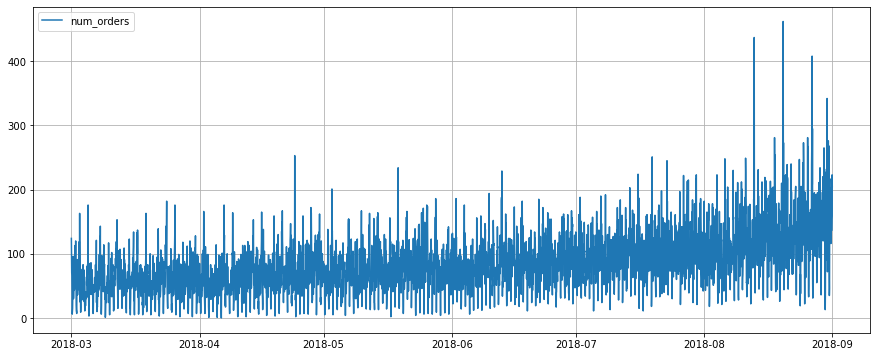

In [6]:
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(df)
ax.legend(df)
ax.grid()
plt.show()

Пункт 2

разбераем временной ряд тренды и сезонность.

In [7]:
decomposed = seasonal_decompose(df)


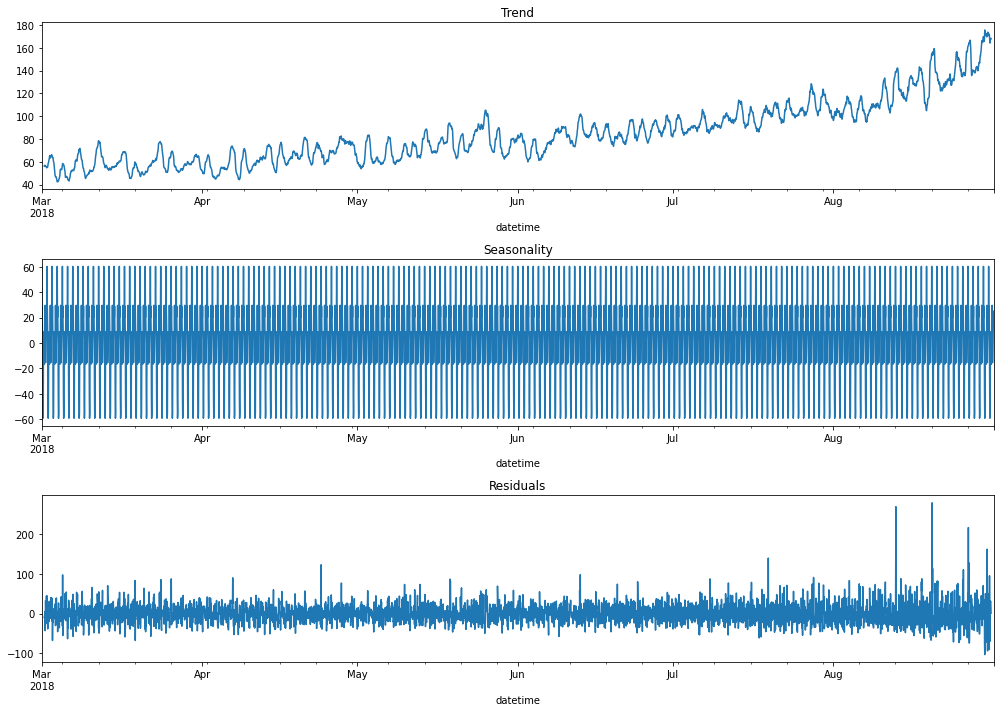

In [8]:
plt.figure(figsize=(14, 10))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Чтобы ряд сделать стационарным, найдём разности его значений.

In [9]:
df_roll = df.copy()

In [10]:
df_roll = df_roll - df_roll.shift()
df_roll['mean'] = df_roll['num_orders'].rolling(15).mean()
df_roll['std'] = df_roll['num_orders'].rolling(15).std()


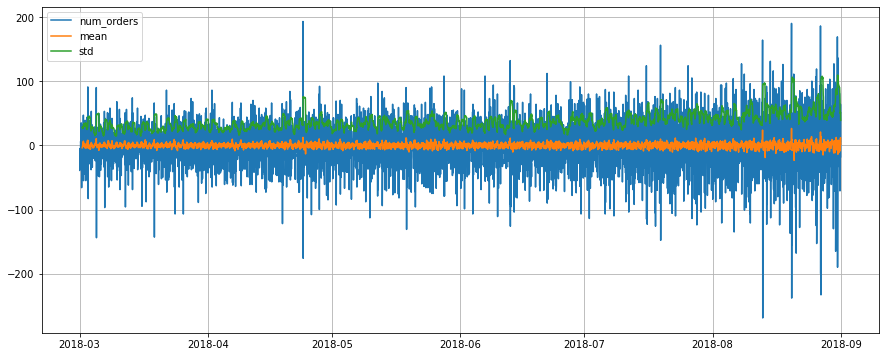

In [11]:
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(df_roll)
ax.legend(df_roll)
ax.grid()
plt.show()

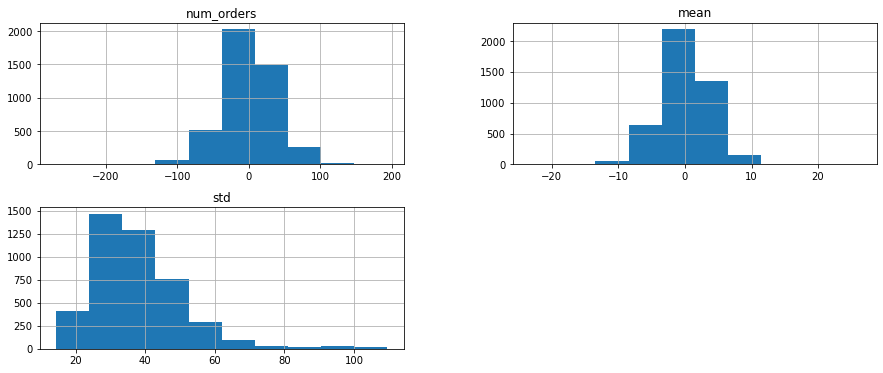

In [12]:
df_roll.hist(figsize=(15, 6))
pyplot.show()

Пункт 3

Рассчитаем среднее количество заказов в день и RMSE:

In [13]:
train, test = train_test_split(df, shuffle=False, test_size=0.10)
train = train.dropna()

In [14]:
print("Среднее количество заказов в день:", test['num_orders'].mean())

pred_previous = test.shift()
pred_previous.iloc[0] = train.iloc[-1]
print("RMSE:", mean_squared_error(test, pred_previous)**0.5)

Среднее количество заказов в день: 139.55656108597285
RMSE: 58.856486242815066


Добавим новые данные. Отстающие значения и скользящее среднее вычислим по прошлым данным. Признаки для первых значений тестовой выборки находятся в конце обучающей выборки.

In [15]:
def make_features(df, max_lag, rolling_mean_size):

    df['dayofweek'] = df.index.dayofweek
    df['hour'] = df.index.hour
    
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return df

df_features = make_features(df, 7, 7)
df_features.head()

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,rolling_mean
datetime,,,,,,,,,,,
2018-03-01 00:00:00,124,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,4,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN


Разделим данные на обучающую и тестовую выборки. 

In [16]:
def split_df (df, max_lag, rolling_mean):

    df_to_split = make_features(df, max_lag=max_lag, rolling_mean_size=rolling_mean)
    
    train, test = train_test_split(df_to_split, shuffle=False, test_size=0.10)
    train = train.dropna()

    features_train = train.drop(['num_orders'], axis=1)
    target_train = train['num_orders']
 
    features_test = train.drop(['num_orders'], axis=1)
    target_test = train['num_orders']
    
    return features_train, target_train, features_test, target_test

Лнейная регрессия

In [17]:
def regression(df):
    
    top_score = 1000
    top_rmse = 1000
    target = None
    
    for lag in range(1,7):
        for rolling_mean in range(1,7):
    
            features_train, target_train, features_test, target_test = split_df(df, lag, rolling_mean)
    
            tscv = TimeSeriesSplit(n_splits=12)
            model = LinearRegression()
            score = abs(cross_val_score(model, features_train, target_train, cv=tscv, scoring='neg_mean_absolute_error').mean())
            
            model.fit(features_train, target_train)
            predictions = model.predict(features_test)
            rmse_test = (mean_squared_error(target_test, predictions))**0.5
            target = target_test
            
            if top_score < score:
                if top_rmse < rmse_test:
                    score = top_score
                    rmse_test = top_rmse
        
            
            
        return score, rmse_test, pd.DataFrame({'Target':target, 'Prediction':predictions})

In [18]:
%%time
make_regression = regression(df)

Wall time: 827 ms


In [19]:
print('Знаение RMSE  Линейной Регрессии на обучающей выборкe - ', round(make_regression[0],2))

Знаение RMSE  Линейной Регрессии на обучающей выборкe -  24.63


In [20]:
print('Знаение RMS  Линейной Регрессии на тестовой выборкe - ', round(make_regression[1],2))

Знаение RMS  Линейной Регрессии на тестовой выборкe -  31.33


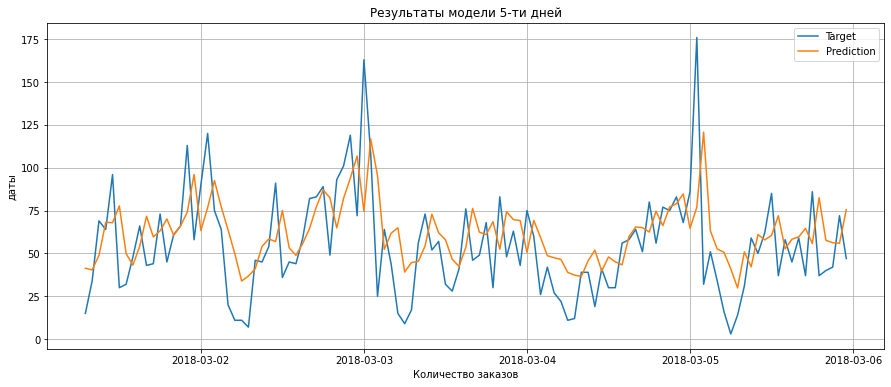

In [21]:
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(make_regression[2]['2018-03-01':'2018-03-05'])
ax.legend(make_regression[2]['2018-03-01':'2018-03-05'])
ax.set_title('Результаты модели 5-ти дней')
ax.set_xlabel('Количество заказов')
ax.set_ylabel('даты')
ax.grid()
plt.show()

Дерево решений

In [22]:
def tree_decision(df):
    
    top_score = 1000
    top_rmse = 1000
    target = None
        
    for depth in range(1, 10):
        for lag in range(1,7):
            for rolling_mean in range(1,7):
    
                features_train, target_train, features_test, target_test = split_df(df, lag, rolling_mean)
                tscv = TimeSeriesSplit(n_splits=8)
                model = DecisionTreeRegressor(random_state=12345, max_depth=depth) 
                score = abs(cross_val_score(model, features_train, target_train, cv=tscv, scoring='neg_mean_absolute_error').mean())
                
        
                model.fit(features_train, target_train)
                predictions = model.predict(features_test)
                rmse_test = (mean_squared_error(target_test, predictions))**0.5
                target = target_test
                
                if top_score < score:
                    if top_rmse < rmse_test:
                        score = top_score
                        rmse_test = top_rmse
                        target = target_test
                    
    return score, rmse_test, pd.DataFrame({'Target':target, 'Prediction':predictions})

In [23]:
df

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,rolling_mean
datetime,,,,,,,,,,,
2018-03-01 00:00:00,124,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,4,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,4,19,207.0,217.0,197.0,116.0,133.0,166.0,136.0,172.666667
2018-08-31 20:00:00,154,4,20,136.0,207.0,217.0,197.0,116.0,133.0,166.0,167.666667
2018-08-31 21:00:00,159,4,21,154.0,136.0,207.0,217.0,197.0,116.0,133.0,171.166667


In [24]:
%%time
make_tree_decision = tree_decision(df)

Wall time: 44.8 s


In [25]:
print('Знаение RMSE Дерево решений на обучающей выборке - ', round(make_tree_decision[0],2))

Знаение RMSE Дерево решений на обучающей выборке -  22.19


In [26]:
print('Знаение RMSE Дерево решений на тестовой выборке - ', round(make_tree_decision[1],2))

Знаение RMSE Дерево решений на тестовой выборке -  19.33


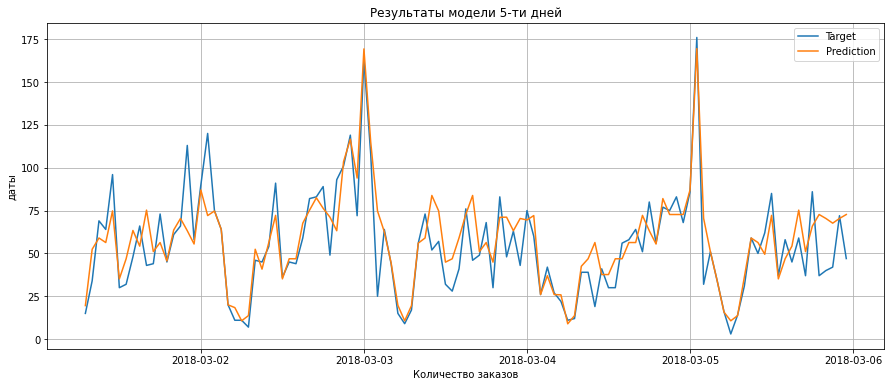

In [27]:
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(make_tree_decision[2]['2018-03-01':'2018-03-05'])
ax.legend(make_tree_decision[2]['2018-03-01':'2018-03-05'])
ax.set_title('Результаты модели 5-ти дней')
ax.set_xlabel('Количество заказов')
ax.set_ylabel('даты')
ax.grid()
plt.show()

Случаный лес

In [28]:
def random_forest(df):
    
    top_score = 1000
    top_rmse = 1000
    target= None 
        
    for estimators in range(1, 5):
        for depth in range(1, 10):
            for lag in range(1,7):
                for rolling_mean in range(1,7):
                    features_train, target_train, features_test, target_test = split_df(df, lag, rolling_mean)
                    tscv = TimeSeriesSplit(n_splits=8)
                    model = RandomForestRegressor(random_state=12345, n_estimators=estimators,  max_depth=depth)
                    score = abs(cross_val_score(model, features_train, target_train, cv=tscv, scoring='neg_mean_absolute_error').mean())
                
        
                    model.fit(features_train, target_train)
                    predictions = model.predict(features_test)
                    rmse_test = (mean_squared_error(target_test, predictions))**0.5
                    target = target_test
                    
                    if top_score < score:
                        if top_rmse < rmse_test:
                            score = top_score
                            rmse_test = top_rmse
                            
                    
    return score, rmse_test, pd.DataFrame({'Target':target, 'Prediction':predictions})
                        
    

In [29]:
%%time
make_random_forest = random_forest(df)

Wall time: 5min 13s


In [30]:
print('Знаение RMSE Случайного леса на обучающей выборке - ', round(make_random_forest[0],2))

Знаение RMSE Случайного леса на обучающей выборке -  19.85


In [31]:
print('Знаение RMSE Случайного леса на тестовой выборке - ', round(make_random_forest[0],2))

Знаение RMSE Случайного леса на тестовой выборке -  19.85


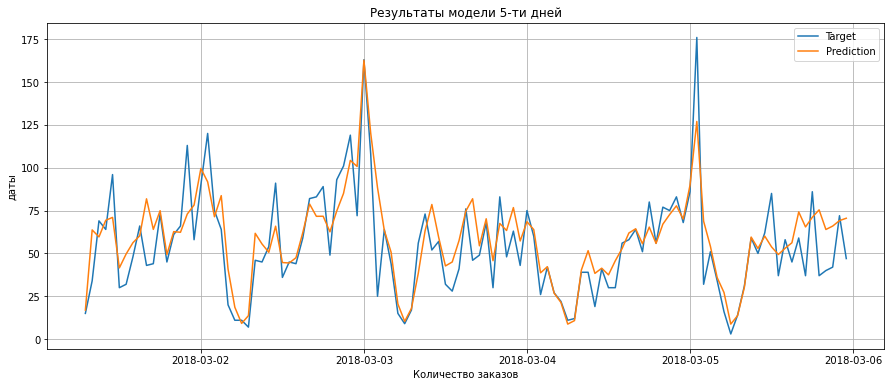

In [32]:
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(make_random_forest[2]['2018-03-01':'2018-03-05'])
ax.legend(make_random_forest[2]['2018-03-01':'2018-03-05'])
ax.set_title('Результаты модели 5-ти дней')
ax.set_xlabel('Количество заказов')
ax.set_ylabel('даты')
ax.grid()
plt.show()

модель LGBMRegressor

In [33]:
def lgbmregress(df):
    
    top_score = 1000
    top_rmse = 1000
    target= None
    
    for lag in range(1,7):
        for rolling_mean in range(1,7):
            features_train, target_train, features_test, target_test = split_df(df, lag, rolling_mean)
            tscv = TimeSeriesSplit(n_splits=8)
    
            model = LGBMRegressor(boosting_type='gbdt', num_leaves=31, max_depth=- 1, learning_rate=0.1, n_estimators=100)
            score = abs(cross_val_score(model, features_train, target_train, cv=tscv, scoring='neg_mean_absolute_error', n_jobs=-1, error_score='raise').mean())
            
            model.fit(features_train, target_train)
            predictions = model.predict(features_test)
            rmse_test = (mean_squared_error(target_test, predictions))**0.5
            target = target_test
                
            if top_score < score:
                if top_rmse < rmse_test:
                    score = top_score
                    rmse_test = top_rmse
                    
                    
    return score, rmse_test, pd.DataFrame({'Target':target, 'Prediction':predictions})
    
    

In [34]:
%%time
make_lgbmregress = lgbmregress(df)

Wall time: 30.6 s


In [35]:
print('Знаение RMSE библиотеки LightGBM на обучающей выборке - ', round(make_lgbmregress[0],2))

Знаение RMSE библиотеки LightGBM на обучающей выборке -  18.77


In [36]:
print('Знаение RMSE библиотеки LightGBM на тестовой выборке - ', round(make_lgbmregress[1],2))

Знаение RMSE библиотеки LightGBM на тестовой выборке -  15.44


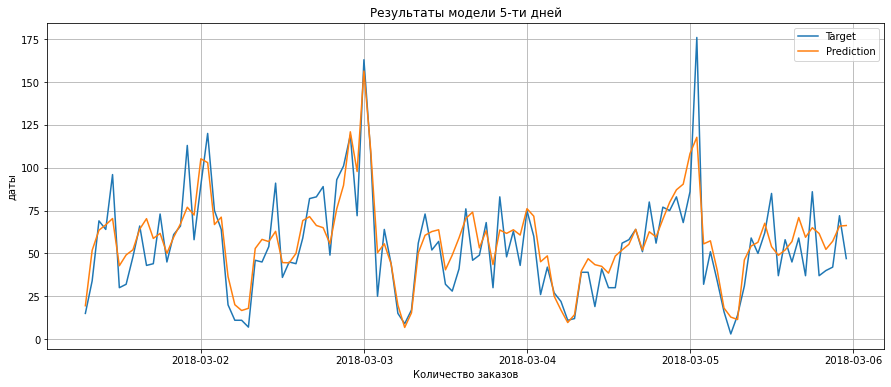

In [37]:
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(make_lgbmregress[2]['2018-03-01':'2018-03-05'])
ax.legend(make_lgbmregress[2]['2018-03-01':'2018-03-05'])
ax.set_title('Результаты модели 5-ти дней')
ax.set_xlabel('Количество заказов')
ax.set_ylabel('даты')
ax.grid()
plt.show()

### Вывод

Обучлили 4 модели и проверили данные на тестовой выборке. В каестве функции потерь был расчет RMSE коорый мы минимизировали:

1) Линейная регрессия </br>
     - Знаение RMSE  Линейной Регрессии на обучающей выборкe -  24.63 </br>
     - Знаение RMS  Линейной Регрессии на тестовой выборкe -  31.33 </br>
Время работы модели - 827 ms </br>
2) Дерево решений </br>
     - Знаение RMSE Дерево решений на обучающей выборке -  22.19 </br>
     - Знаение RMSE Дерево решений на тестовой выборке -  19.33 </br>
Время работы модели - 44.8 s </br>
3) Случайный лес </br>
     - Знаение RMSE Случайного леса на обучающей выборке -  19.85 </br>
     - Знаение RMSE Случайного леса на тестовой выборке -  19.85 </br>
Время работы модели - 5min 13s </br>
4) библиотекa LightGBM </br>
     - Знаение RMSE модель LGBMRegressor на обучающей выборке -  18.51 </br>
     - Знаение RMSE модель LGBMRegressor на тестовой выборке -  15.44</br>
Время работы модели - 30.6 s

Лучший результат показала модель LGBMRegressor

     

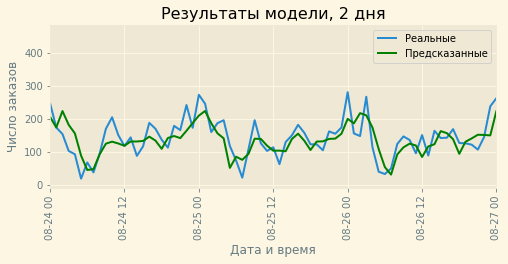